In [13]:
# LOCATION : https://github.com/purnasai/Dino_V2
import torch
import os

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [14]:
# large model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)

Using cache found in /home/osero/.cache/torch/hub/facebookresearch_dinov2_main


In [15]:
dinov2_vitl14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

In [16]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [17]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = "harryported_giffin_images/"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 1024])

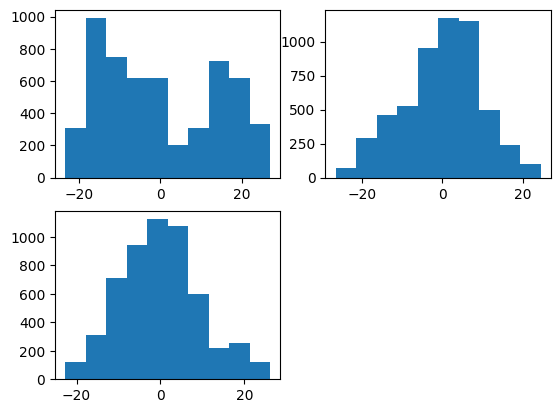

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim).cpu()#4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

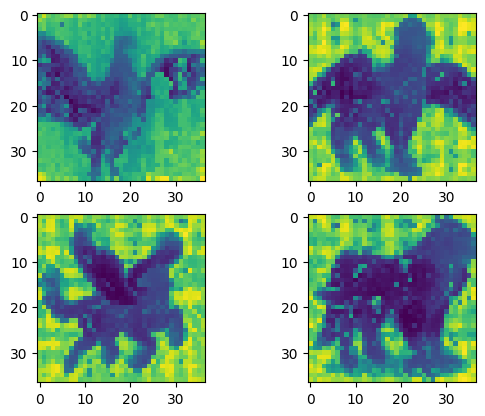

In [38]:
# min_max scale
# pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
#                      (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

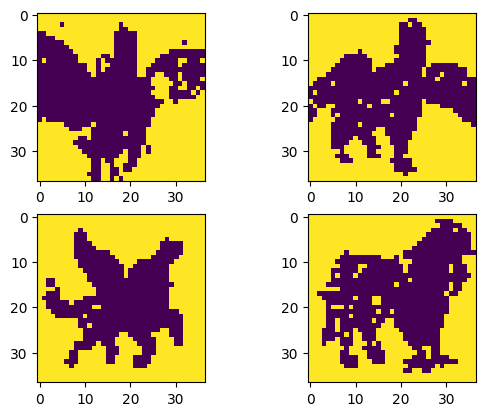

In [39]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


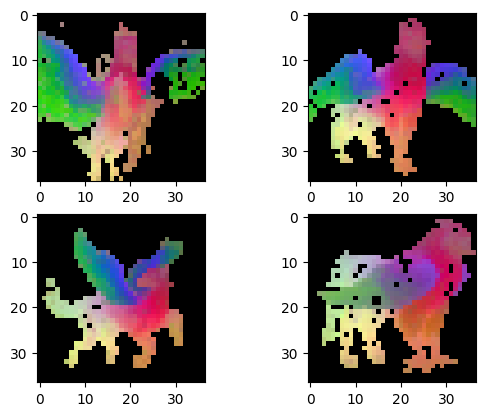

In [21]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

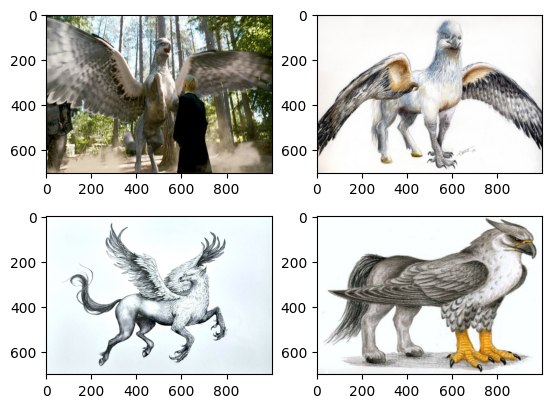

In [22]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()

In [23]:
import gc


dinov2_vitl14 = None
gc.collect()
torch.cuda.empty_cache()